## Preface



If need be&#x2026;



In [1]:
!pip install -r requirements.txt

## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:


| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|i,t,m|j|
| Consumption|i,t,m,u|j|
| Prices|j,u|t,m|
| HH Characteristics|i,t,m|k|
| FCT|j,u|n|
| RDI|n|k|

where `i` indexes households, `t` indexes periods, `m` indexes
markets, `j` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



## Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [2]:
InputFiles = {'Expenditures':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Expenditures (2011-12)'),
              'Prices':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Food Prices (2011-12)'),
              'HH Characteristics':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','Household Characteristics'),
              'FCT':('1qOZi1FqAS89x461pCIgwRaAfpBw5aUp7kBbp0tQKI_E','FCT'),
              'RDI':('1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ','RDI'),}

Note that in some cases not the food items for the FCT (e.g., for Niger) are **not** yet all matched up (&ldquo;harmonized&rdquo;) with food labels indexed by `j` in the expenditure,
consumption and price datasets.



In [53]:
from eep153_tools.sheets import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,sheet=None):

    df = read_sheets(key,sheet=sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

## important to keep the type of household id value as str.
x['i'] = x['i'].astype(str)

x = x.set_index(['i','t','m', 'j'])


# x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['i','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get prices
p = get_clean_sheet(InputFiles['Prices'][0],
                    sheet=InputFiles['Prices'][1])

if 'm' not in p.columns:  # Supply "market" indicator if missing
    p['m'] = 1

p = p[p['u'] == 'Kg']
p = p.drop(columns = ['u'])
p = p.set_index(['t','m', 'j'])

p = p.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    sheet=InputFiles['FCT'][1])

#### This bit peculiar to Niger FCT #####
#fct = fct.loc[fct.Code.str.len()==6]
#fct = fct.set_index('Code')
#fct.columns = [v.replace('\n',' ') for v in fct.columns]
########################################
fct = fct.rename(columns={'index':'j'})
fct = fct.set_index('j')
fct.columns.name = 'n'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

################## RDI, if available (consider using US) #####################
rdi = get_clean_sheet(InputFiles['RDI'][0],
                    sheet=InputFiles['RDI'][1])
rdi = rdi.set_index('n')
rdi.columns.name = 'k'

## Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `Regression` result.



In [25]:
import cfe

result = cfe.Regression(y=np.log(x['Expenditure']),d=z)

result.get_beta().sort_values(ascending=False) # Check sanity...

j
Maize        0.677973
Wheat        0.631319
Teff         0.567075
Coffee       0.539258
Banana       0.527397
Onion        0.510546
Sugar        0.492017
Chat/Kat     0.459318
Meat         0.440854
Field Pea    0.425250
Sorghum      0.377076
Potato       0.336244
Milk         0.286823
Eggs         0.275389
Salt         0.228052
Name: beta, dtype: float64

Make this persistent&#x2026;



In [26]:
result.to_pickle('./foo.pickle')

## Step 3: Infer quantities



Next, we divide predicted expenditures by prices to get
quantities (in kilograms) we can map into the  FCT.



In [66]:
import cfe

result = cfe.read_pickle('foo.pickle')  # Get persistent result saved above...

xhat = result.predicted_expenditures()

# Expenditures divided by prices/kg gives quantities in kgs...
qhat = (xhat.unstack('j')/p['Price'].unstack('j')).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

Note that `qhat` may give prices for different *units*.  If prices
differ **only** because of units (e.g., one deciliter costs one
tenth as much as a liter), then we can use these differences in prices
to convert between different units, even if the units (e.g., &ldquo;basket&rdquo;)
is otherwise unclear.  

If we have enough data on purchases in kilograms, just keep those
prices (otherwise choose some other useful unit).  We also assume
prices are the same for everyone, so just take median.



## Step 4: Map predicted quantities into nutrients



Before this will work, need columns of qhat to match columns of fct.



In [68]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

n
Energy          108337.974482
Protein           1773.826524
Vitamin A        10816.594128
Vitamin D           90.194739
Vitamin E           94.870811
Vitamin C          510.109951
Vitamin B-6         51.959447
Vitamin B-12       101.994660
Calcium          28347.784970
Magnesium        14160.044863
Iron               655.914074
Zinc               307.973854
Fiber              391.916338
Folate               0.000000
Carbohydrate      3582.605228
Niacin             164.751831
Phosphorus       21016.513643
Potassium        20918.534558
Riboflavin          13.227176
Thiamin             19.105921
Vitamin K           93.080130
dtype: float64

## Household Nutritional Adequacy



Our data on demand and nutrients is at the *household* level; we
   can&rsquo;t directly compare household level nutrition with individual
   level requirements.  What we **can** do is add up minimum individual
   requirements, and see whether household total exceed these.  This
   isn&rsquo;t a guarantee that all individuals have adequate nutrition
   (since the way food is allocated in the household might be quite
   unequal, or unrelated to individual requirements), but it is
   *necessary* if all individuals are to have adequate nutrition.

For each household, we know the numbers of people in different age-sex categories.  We can match these up with data from an RDI (Recommended Dietary Intakes), then sum over different types.



In [74]:
z.columns = [
    col.replace('Females', 'F')
       .replace('Males', 'M')
       .replace('51-99', '51+')
    for col in z.columns
]

In [75]:
z = z[rdi.columns.tolist()]

hh_rdi = z@rdi.T

# Uganda data is per week, so make this a recommended WEEKLY intake:
hh_rwi = hh_rdi*7

Now, what proportion of `hh_rwi` do households consume?



In [76]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

n                               Energy   Protein  Vitamin A  Vitamin E  \
i             t       m                                                  
1010101601002 2011-12 Tigray  1.310347  0.886001   0.265225   0.131576   
1010101601017 2011-12 Tigray  1.210821  0.847072   0.245175   0.124396   
1010101601034 2011-12 Tigray  3.032163  2.018431   1.333719   0.454529   
1010101601049 2011-12 Tigray  2.626463  1.880298   0.938592   0.321365   
1010101601064 2011-12 Tigray  1.348433  0.966431   0.536089   0.180680   
...                                ...       ...        ...        ...   
7210106202111 2011-12 SNNP    1.040630  0.943546   0.279637   0.245367   
7210106202132 2011-12 SNNP    2.512957  1.971343   0.952008   0.472882   
7210106202153 2011-12 SNNP    2.420857  1.552993   0.221385   0.253619   
7210106202174 2011-12 SNNP    0.981211  0.905354   0.285187   0.236739   
7210106202195 2011-12 SNNP    1.901144  1.624888   0.476587   0.386567   

n                             Vitamin C  Vitamin B-6  Vitamin B-12   Calcium  \
i             t       m                                                        
1010101601002 2011-12 Tigray   0.122671     0.976634      0.819656  0.651046   
1010101601017 2011-12 Tigray   0.102872     0.951404      0.762986  0.580121   
1010101601034 2011-12 Tigray   0.298017     1.858395      3.814419  1.453096   
1010101601049 2011-12 Tigray   0.260184     1.886321      2.779614  1.173402   
1010101601064 2011-12 Tigray   0.117767     0.989263      1.683218  0.778538   
...                                 ...          ...           ...       ...   
7210106202111 2011-12 SNNP     0.211181     1.017547      0.942135  0.567244   
7210106202132 2011-12 SNNP     0.318124     1.908674      3.110882  1.277862   
7210106202153 2011-12 SNNP     0.243561     1.747733      0.637712  0.927124   
7210106202174 2011-12 SNNP     0.180918     0.973980      0.915833  0.456376   
7210106202195 2011-12 SNNP     0.329559     1.768740      1.515462  0.891492   

n                             Magnesium      Iron      Zinc     Fiber  Folate  \
i             t       m                                                         
1010101601002 2011-12 Tigray   0.985070  1.461778  0.803603  0.319416     0.0   
1010101601017 2011-12 Tigray   0.949062  1.306220  0.749866  0.301396     0.0   
1010101601034 2011-12 Tigray   1.949842  4.258134  1.859290  0.644300     0.0   
1010101601049 2011-12 Tigray   2.030124  2.836617  1.661981  0.624304     0.0   
1010101601064 2011-12 Tigray   0.894910  1.360764  0.821282  0.292709     0.0   
...                                 ...       ...       ...       ...     ...   
7210106202111 2011-12 SNNP     0.854397  0.980245  0.660251  0.225816     0.0   
7210106202132 2011-12 SNNP     1.767697  2.575238  1.499150  0.584044     0.0   
7210106202153 2011-12 SNNP     1.831372  2.331646  1.410650  0.687051     0.0   
7210106202174 2011-12 SNNP     0.861373  0.988922  0.658424  0.236241     0.0   
7210106202195 2011-12 SNNP     1.598125  1.750525  1.212672  0.448485     0.0   

n                             Carbohydrate    Niacin  Phosphorus  Potassium  \
i             t       m                                                       
1010101601002 2011-12 Tigray      0.566004  0.257457    0.475827   0.095171   
1010101601017 2011-12 Tigray      0.514292  0.249289    0.416502   0.087725   
1010101601034 2011-12 Tigray      1.014842  0.433356    1.105619   0.163899   
1010101601049 2011-12 Tigray      1.044805  0.480470    0.817214   0.172406   
1010101601064 2011-12 Tigray      0.518680  0.221486    0.405695   0.084669   
...                                    ...       ...         ...        ...   
7210106202111 2011-12 SNNP        0.392735  0.190368    0.329731   0.068269   
7210106202132 2011-12 SNNP        1.034924  0.441932    0.893489   0.169547   
7210106202153 2011-12 SNNP        1.246439  0.566965    1.047853   0.209584   
7210106202174 2011-12 SNNP        0.403113  0.206564    0.376433   0.0706

Graph ratios of adequacy for particular nutrients



<Axes: >

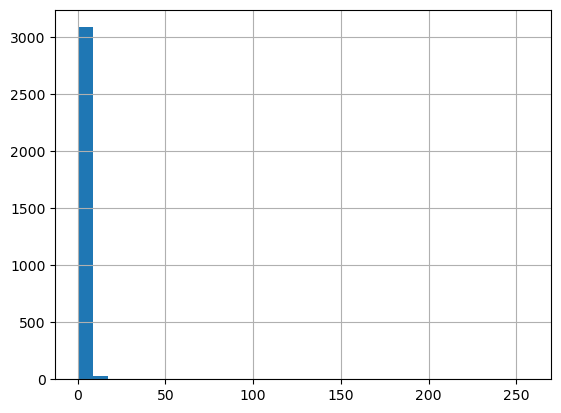

In [77]:
%matplotlib inline
nutrient_ratio['Energy'].hist(bins=30)